In [47]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
import joblib

# Load dataset
data_df = pd.read_csv('games.csv')
print("Dataset shape:", data_df.shape)
data_df.info()

Dataset shape: (20058, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memor

In [48]:
# Rename columns for easier reference
data_df.columns = [
    'Game_ID', 'Rated_(T/F)', 'Start_Time', 'End_Time', 
    'Number_of_Turns', 'Game_Status', 'Winner', 'Time_Increment',
    'White_ID', 'White_Rating', 'Black_ID',
    'Black_Rating', 'Moves',
    'Opening_Eco', 'Opening_Name', 'Opening_Ply'
]

In [49]:
print("Columns in DataFrame: \n",data_df.columns)
print("Info: \n",data_df.info)
print("NA Values: \n",data_df.isna().sum())
print("Null Values: \n",data_df.isnull().sum())

Columns in DataFrame: 
 Index(['Game_ID', 'Rated_(T/F)', 'Start_Time', 'End_Time', 'Number_of_Turns',
       'Game_Status', 'Winner', 'Time_Increment', 'White_ID', 'White_Rating',
       'Black_ID', 'Black_Rating', 'Moves', 'Opening_Eco', 'Opening_Name',
       'Opening_Ply'],
      dtype='object')
Info: 
 <bound method DataFrame.info of         Game_ID  Rated_(T/F)    Start_Time      End_Time  Number_of_Turns  \
0      TZJHLljE        False  1.504210e+12  1.504210e+12               13   
1      l1NXvwaE         True  1.504130e+12  1.504130e+12               16   
2      mIICvQHh         True  1.504130e+12  1.504130e+12               61   
3      kWKvrqYL         True  1.504110e+12  1.504110e+12               61   
4      9tXo1AUZ         True  1.504030e+12  1.504030e+12               95   
...         ...          ...           ...           ...              ...   
20053  EfqH7VVH         True  1.499791e+12  1.499791e+12               24   
20054  WSJDhbPl         True  1.499698e+12  

### Simplification of Data

In [50]:
# Convert timestamps to raw numeric values in minutes
data_df['Start_Time'] = data_df['Start_Time'] / 60000
data_df['End_Time'] = data_df['End_Time'] / 60000

# Calculate 'Game_Duration' in minutes (no need to use .dt.total_seconds())
data_df['Game_Duration_(M)'] = data_df['End_Time'] - data_df['Start_Time']

# Handle cases with zero duration (if Start_Time == End_Time)
data_df.loc[data_df['Start_Time'] == data_df['End_Time'], 'Game_Duration_(M)'] = 1

# Remove rows where Game_Duration is 1 minute (assuming zero duration is invalid)
data_df = data_df[data_df['Game_Duration_(M)'] > 1]

# Remove rows where Game_Duration is divisible by 10
data_df = data_df[data_df['Game_Duration_(M)'] % 10 != 0]

# Remove duplicate rows based on 'Game_Duration' (keep=False removes all duplicates)
data_df = data_df[~data_df['Game_Duration_(M)'].duplicated(keep=False)]

# Round 'Game_Duration' to 2 decimal places
data_df['Game_Duration_(M)'] = data_df['Game_Duration_(M)'].round(2)


In [51]:
# 2. Calculate Elo Difference
data_df['Elo_Difference'] = data_df['White_Rating'] - data_df['Black_Rating']

In [52]:
# 3. Categorize Game Duration
def categorize_duration(duration):
    if duration < 300:  # Less than 5 minutes
        return 'Short'
    elif duration < 900:  # 5-15 minutes
        return 'Medium'
    else:
        return 'Long'

data_df['Duration_Category'] = data_df['End_Time'] - data_df['Start_Time']
data_df['Duration_Category'] = data_df['Duration_Category'].apply(categorize_duration)

In [53]:
# 4. Opening Analysis
data_df['Opening'] = data_df['Opening_Name']

In [54]:
# 5. Time per Move
data_df['Time_Per_Move_(S)'] = (data_df['Game_Duration_(M)']*60) / data_df['Number_of_Turns']
data_df['Time_Per_Move_(S)'] = data_df['Time_Per_Move_(S)'].round(2)

In [55]:
# 6. Elo Rating Tier
bins = [0, 1200, 1600, 2000, float('inf')]
labels = ['Beginner', 'Intermediate', 'Advanced', 'Master']
data_df['White_Rating_Tier'] = pd.cut(data_df['White_Rating'], bins=bins, labels=labels)
data_df['Black_Rating_Tier'] = pd.cut(data_df['Black_Rating'], bins=bins, labels=labels)


In [56]:
# Drop specific columns
data_df = data_df.drop(['Start_Time', 'End_Time','White_ID','Black_ID','White_Rating', 'Black_Rating','Opening_Name',], axis=1)

In [57]:
data_df.columns

Index(['Game_ID', 'Rated_(T/F)', 'Number_of_Turns', 'Game_Status', 'Winner',
       'Time_Increment', 'Moves', 'Opening_Eco', 'Opening_Ply',
       'Game_Duration_(M)', 'Elo_Difference', 'Duration_Category', 'Opening',
       'Time_Per_Move_(S)', 'White_Rating_Tier', 'Black_Rating_Tier'],
      dtype='object')

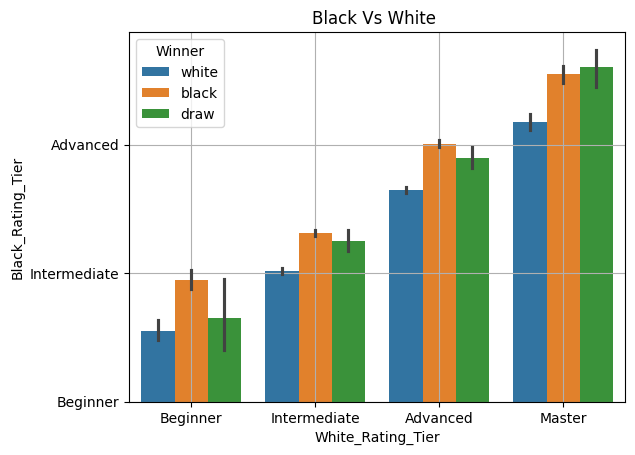

In [58]:
sns.barplot(data=data_df,x = "White_Rating_Tier", y = "Black_Rating_Tier", hue="Winner")
plt.title("Black Vs White ")
plt.grid(True)
plt.gca().invert_yaxis()

plt.show()

C:\Users\Kshitish Pandit\AppData\Local\Temp\ipykernel_6796\752029121.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_openings.values, y=top_openings.index, palette="Blues_d",hue= None)


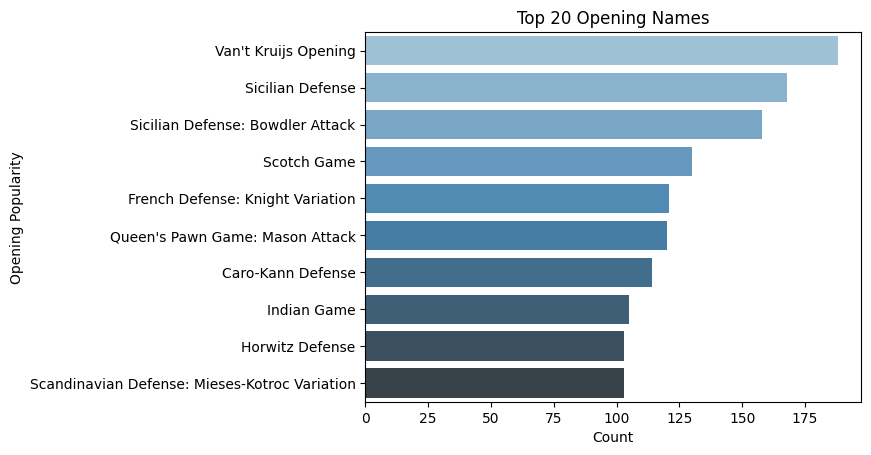

In [59]:
# Now, calculate the top 10 most frequent opening eco codes (or names)
top_openings = data_df['Opening'].value_counts().head(10)

# Create the bar plot for top openings
sns.barplot(x=top_openings.values, y=top_openings.index, palette="Blues_d",hue= None)
plt.title("Top 20 Opening Names")
plt.xlabel("Count")
plt.ylabel("Opening Popularity")
plt.show()

In [60]:
Winner = data_df['Opening']
Winner.to_csv('Winner.csv', index=False)

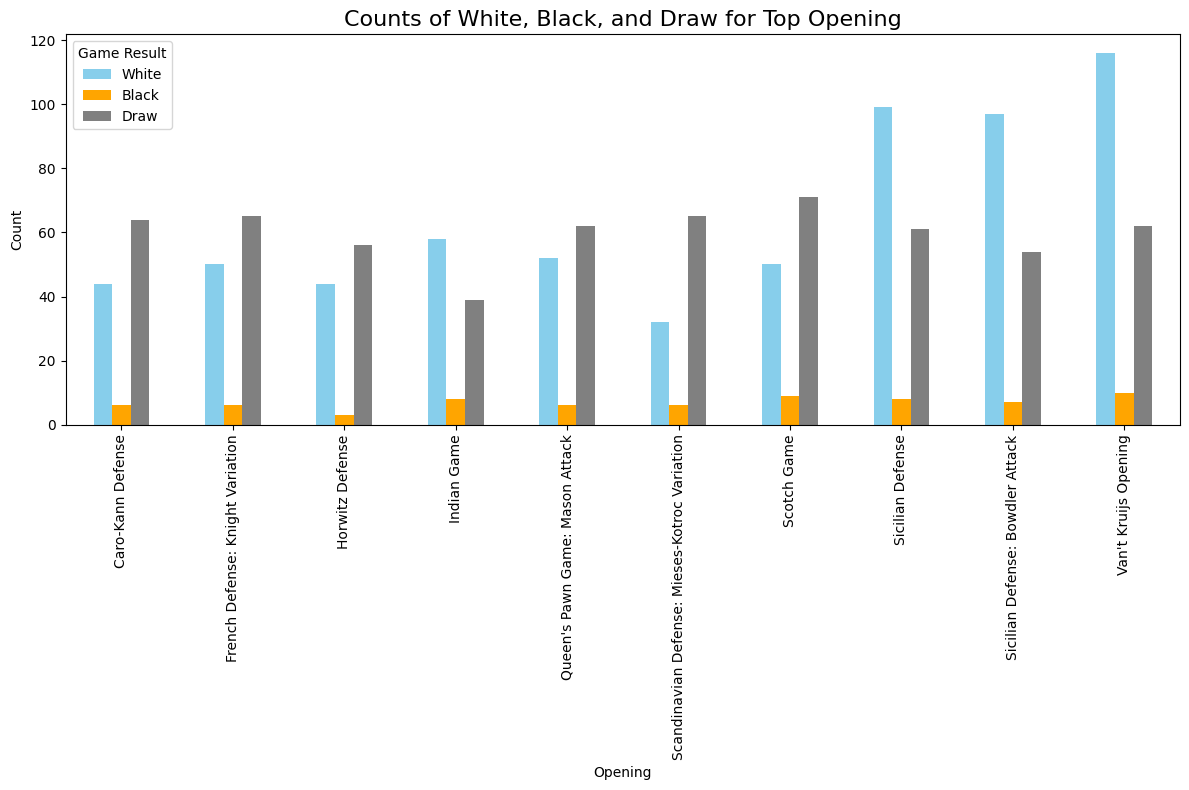

In [61]:
# Get the top 20 most common openings
top_openings = data_df['Opening'].value_counts().head(10).index

# Filter data for the top 20 openings
filtered_data = data_df[data_df['Opening'].isin(top_openings)]

# Group by 'Opening' and 'Winner' to count occurrences of 'white', 'black', and 'draw'
counts = filtered_data.groupby(['Opening', 'Winner']).size().unstack(fill_value=0)

# Plot the data
counts.plot(
    kind='bar', 
    figsize=(12, 8), 
    stacked=False,  # Separate bars for each result type
    color=['skyblue', 'orange', 'gray']  # Colors for white, black, and draw
)

# Add labels and title
plt.title('Counts of White, Black, and Draw for Top Opening', fontsize=16)
plt.xlabel('Opening')
plt.ylabel('Count')
plt.xticks(rotation=90)  
plt.legend(title="Game Result", labels=['White', 'Black', 'Draw'])
plt.tight_layout()  # Adjust layout to fit everything

# Show the plot
plt.show()


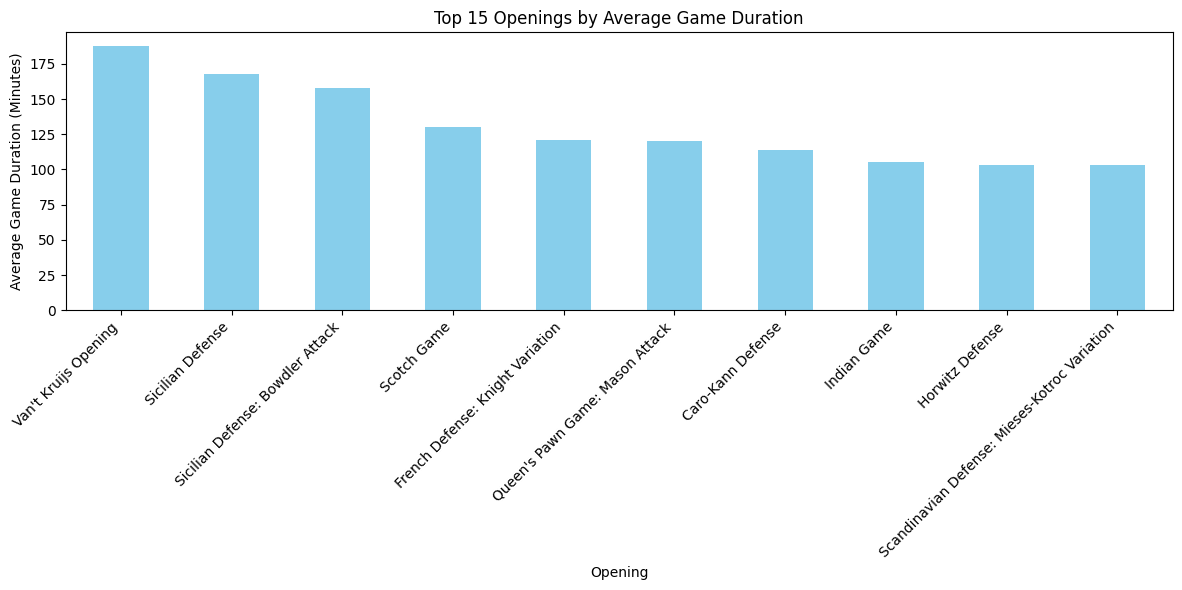

In [62]:
# Group by 'Opening' and calculate the mean of 'Game_Duration_(M)'
avg_duration = data_df.groupby('Opening')['Game_Duration_(M)'].mean().sort_values(ascending=False)

# Select the top 15 openings based on average game duration
top_15_openings = data_df['Opening'].value_counts().head(10)
# Plotting the bar chart
import matplotlib.pyplot as plt

top_15_openings.plot(kind='bar', figsize=(12, 6), color='skyblue')

# Add labels and title
plt.title('Top 15 Openings by Average Game Duration')
plt.xlabel('Opening')
plt.ylabel('Average Game Duration (Minutes)')

# Rotate x-axis labels to make them more readable
plt.xticks(rotation=45, ha='right')  # Rotate the labels by 45 degrees and align to the right
plt.tight_layout()  # Adjust layout to fit everything

# Show the plot
plt.show()



In [63]:
# Count the occurrences of each opening
opening_counts = data_df['Opening'].value_counts()

# Top 10 most played openings
most_played_10 = opening_counts.head(10)

# Bottom 20 least played openings
least_played_20 = opening_counts.tail(20)

# Display the results
print("Top 10 Most Played Openings:")
print(most_played_10)

print("\nBottom 20 Least Played Openings:")
print(least_played_20)


Top 10 Most Played Openings:
Opening
Van't Kruijs Opening                             188
Sicilian Defense                                 168
Sicilian Defense: Bowdler Attack                 158
Scotch Game                                      130
French Defense: Knight Variation                 121
Queen's Pawn Game: Mason Attack                  120
Caro-Kann Defense                                114
Indian Game                                      105
Horwitz Defense                                  103
Scandinavian Defense: Mieses-Kotroc Variation    103
Name: count, dtype: int64

Bottom 20 Least Played Openings:
Opening
Nimzo-Indian Defense: Classical |  Noa Variation |  5.cxd5 exd5                  1
Queen's Indian Defense: Classical Variation |  Polugaevsky Gambit                1
Queen's Pawn Game: Torre Attack |  Gruenfeld Variation                           1
Trompowsky Attack: Classical Defense |  Big Center Variation                     1
Semi-Slav Defense: Stoltz Variati

In [64]:
data_df.columns

Index(['Game_ID', 'Rated_(T/F)', 'Number_of_Turns', 'Game_Status', 'Winner',
       'Time_Increment', 'Moves', 'Opening_Eco', 'Opening_Ply',
       'Game_Duration_(M)', 'Elo_Difference', 'Duration_Category', 'Opening',
       'Time_Per_Move_(S)', 'White_Rating_Tier', 'Black_Rating_Tier'],
      dtype='object')

### Feature Enginerring

In [65]:
#Label Encoding
le = LabelEncoder()
encoded_moves = le.fit_transform(data_df['Moves'])
data_df['Moves'] = encoded_moves

In [66]:
encoded_openings = le.fit_transform(data_df['Opening'])
data_df['Opening'] = encoded_openings

In [67]:
data_df.shape

(9655, 16)

In [68]:
data_df.to_csv("Data1.csv")